In [27]:
# Install dependencies if needed
# !pip install polars numpy pandas matplotlib seaborn networkx

In [28]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime, timedelta
from pathlib import Path

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# EventFlow imports
import sys
sys.path.insert(0, str(Path.cwd().parent / "src"))

from eventflow.core.adapters import (
    TableAdapter, TableAdapterConfig,
    SequenceAdapter, SequenceAdapterConfig,
    RasterAdapter, RasterAdapterConfig,
    GraphAdapter, GraphAdapterConfig,
    StreamAdapter, StreamAdapterConfig,
)

print("✅ EventFlow adapters loaded successfully!")

✅ EventFlow adapters loaded successfully!


# EventFlow Demo: Real Chicago Crime Data Analysis

This notebook demonstrates EventFlow's **5 multi-modal adapters** using **real Chicago crime data** from the City of Chicago Data Portal (60,000+ records from 2024 Q1).

| Adapter | Output Format | Target Models |
|---------|---------------|---------------|
| **TableAdapter** | `(N, F)` DataFrame | GLM, XGBoost, Poisson regression |
| **SequenceAdapter** | `(B, T, F)` tensors | LSTM, Transformer, temporal models |
| **RasterAdapter** | `(T, C, H, W)` arrays | CNN, ConvLSTM, U-Net |
| **GraphAdapter** | Nodes + edges | GNN, GAT, GCN |
| **StreamAdapter** | Continuous timestamps | Neural ODE, Hawkes processes |

---

## 1. Load Real Chicago Crime Data

Loading actual crime records from `chicago_crime_data_cli` project (downloaded via Socrata API).

In [29]:
# Load REAL Chicago Crime Data from chicago_crime_data_cli project
data_path = Path.cwd().parent.parent / "chicago_crime_data_cli" / "data" / "monthly_2020_2025" / "monthly"

# Load multiple months of real data (2024)
dfs = []
for month in ["2024-01", "2024-02", "2024-03"]:  # 3 months of data
    csv_path = data_path / month / f"{month}_chunk_0001.csv"
    if csv_path.exists():
        df = pl.read_csv(csv_path)
        dfs.append(df)
        print(f"✅ Loaded {month}: {len(df):,} records")

crime_df = pl.concat(dfs)

# Clean and prepare the data
crime_df = crime_df.filter(
    (pl.col("latitude").is_not_null()) & 
    (pl.col("longitude").is_not_null())
).with_columns([
    pl.col("date").str.to_datetime().alias("timestamp"),
    pl.col("arrest").cast(pl.Boolean),
    pl.col("domestic").cast(pl.Boolean),
])

# Chicago bounds
lat_min, lat_max = 41.64, 42.02
lon_min, lon_max = -87.94, -87.52

# Crime types from real data
crime_types = crime_df["primary_type"].unique().to_list()

print(f"\n📊 Total records: {len(crime_df):,}")
print(f"📅 Date range: {crime_df['timestamp'].min()} to {crime_df['timestamp'].max()}")
print(f"🏷️ Crime types: {len(crime_types)} unique types")
print(f"📍 Columns: {crime_df.columns}")

crime_df.head(10)

✅ Loaded 2024-01: 19,622 records
✅ Loaded 2024-02: 19,933 records
✅ Loaded 2024-03: 20,904 records

📊 Total records: 60,245
📅 Date range: 2024-01-01 00:00:00 to 2024-03-31 23:59:00
🏷️ Crime types: 30 unique types
📍 Columns: ['id', 'case_number', 'date', 'block', 'iucr', 'primary_type', 'description', 'location_description', 'arrest', 'domestic', 'beat', 'district', 'ward', 'community_area', 'fbi_code', 'x_coordinate', 'y_coordinate', 'year', 'updated_on', 'latitude', 'longitude', 'location', 'timestamp']


id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location,timestamp
i64,str,str,str,str,str,str,str,bool,bool,i64,i64,i64,i64,str,i64,i64,i64,str,f64,f64,str,datetime[μs]
13354701,"""JH135673""","""2024-01-31T23:53:00.000""","""085XX W CATHERINE AVE""","""0486""","""BATTERY""","""DOMESTIC BATTERY SIMPLE""","""APARTMENT""",false,true,1614,16,41,76,"""08B""",1118470,1934756,2024,"""2024-12-21T15:40:46.000""",41.977441,-87.839712,"""{'latitude': '41.97744068', 'l…",2024-01-31 23:53:00
13354697,"""JH135694""","""2024-01-31T23:52:00.000""","""098XX S HOXIE AVE""","""0560""","""ASSAULT""","""SIMPLE""","""RESIDENCE""",true,true,431,4,7,51,"""08A""",1195082,1840279,2024,"""2024-12-21T15:40:46.000""",41.716636,-87.561101,"""{'latitude': '41.716635712', '…",2024-01-31 23:52:00
13354735,"""JH135671""","""2024-01-31T23:45:00.000""","""045XX N CLARENDON AVE""","""1310""","""CRIMINAL DAMAGE""","""TO PROPERTY""","""APARTMENT""",false,true,1914,19,46,3,"""14""",1170091,1930547,2024,"""2024-12-21T15:40:46.000""",41.964918,-87.650001,"""{'latitude': '41.96491786', 'l…",2024-01-31 23:45:00
13354646,"""JH135686""","""2024-01-31T23:35:00.000""","""050XX S CICERO AVE""","""1506""","""PROSTITUTION""","""SOLICIT ON PUBLIC WAY""","""STREET""",false,false,815,8,14,56,"""16""",1145210,1870880,2024,"""2024-12-21T15:40:46.000""",41.801693,-87.742992,"""{'latitude': '41.801692642', '…",2024-01-31 23:35:00
13354729,"""JH135674""","""2024-01-31T23:32:00.000""","""006XX E 42ND ST""","""1310""","""CRIMINAL DAMAGE""","""TO PROPERTY""","""APARTMENT""",false,false,214,2,4,38,"""14""",1181389,1877298,2024,"""2024-12-21T15:40:46.000""",41.818546,-87.610111,"""{'latitude': '41.81854567', 'l…",2024-01-31 23:32:00
13359386,"""JH141458""","""2024-01-31T23:30:00.000""","""065XX W CORNELIA AVE""","""0820""","""THEFT""","""$500 AND UNDER""","""STREET""",false,false,1632,16,38,17,"""06""",1131974,1922560,2024,"""2024-12-21T15:40:46.000""",41.943749,-87.790335,"""{'latitude': '41.943749315', '…",2024-01-31 23:30:00
13354699,"""JH135668""","""2024-01-31T23:28:00.000""","""043XX N CENTRAL AVE""","""0860""","""THEFT""","""RETAIL THEFT""","""DRUG STORE""",false,false,1624,16,45,15,"""06""",1138223,1928483,2024,"""2024-12-21T15:40:46.000""",41.959892,-87.767223,"""{'latitude': '41.959891679', '…",2024-01-31 23:28:00
13354641,"""JH135658""","""2024-01-31T23:27:00.000""","""002XX W 115TH ST""","""1320""","""CRIMINAL DAMAGE""","""TO VEHICLE""","""RESIDENCE""",false,true,522,5,9,49,"""14""",1176800,1828686,2024,"""2024-12-21T15:40:46.000""",41.685253,-87.628406,"""{'latitude': '41.685253328', '…",2024-01-31 23:27:00
13354640,"""JH135672""","""2024-01-31T23:15:00.000""","""016XX N MC VICKER AVE""","""0820""","""THEFT""","""$500 AND UNDER""","""APARTMENT""",false,true,2513,25,29,25,"""06""",1135831,1910190,2024,"""2024-12-21T15:40:46.000""",41.909737,-87.776454,"""{'latitude': '41.909736709', '…",2024-01-31 23:15:00


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\270787906.py:47: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\270787906.py:47: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\270787906.py:47: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\270787906.py:47: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\270787906.py:47: UserWarning: Glyph 128336 (\N{CLOCK FACE ONE OCLOCK}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Administrator\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing

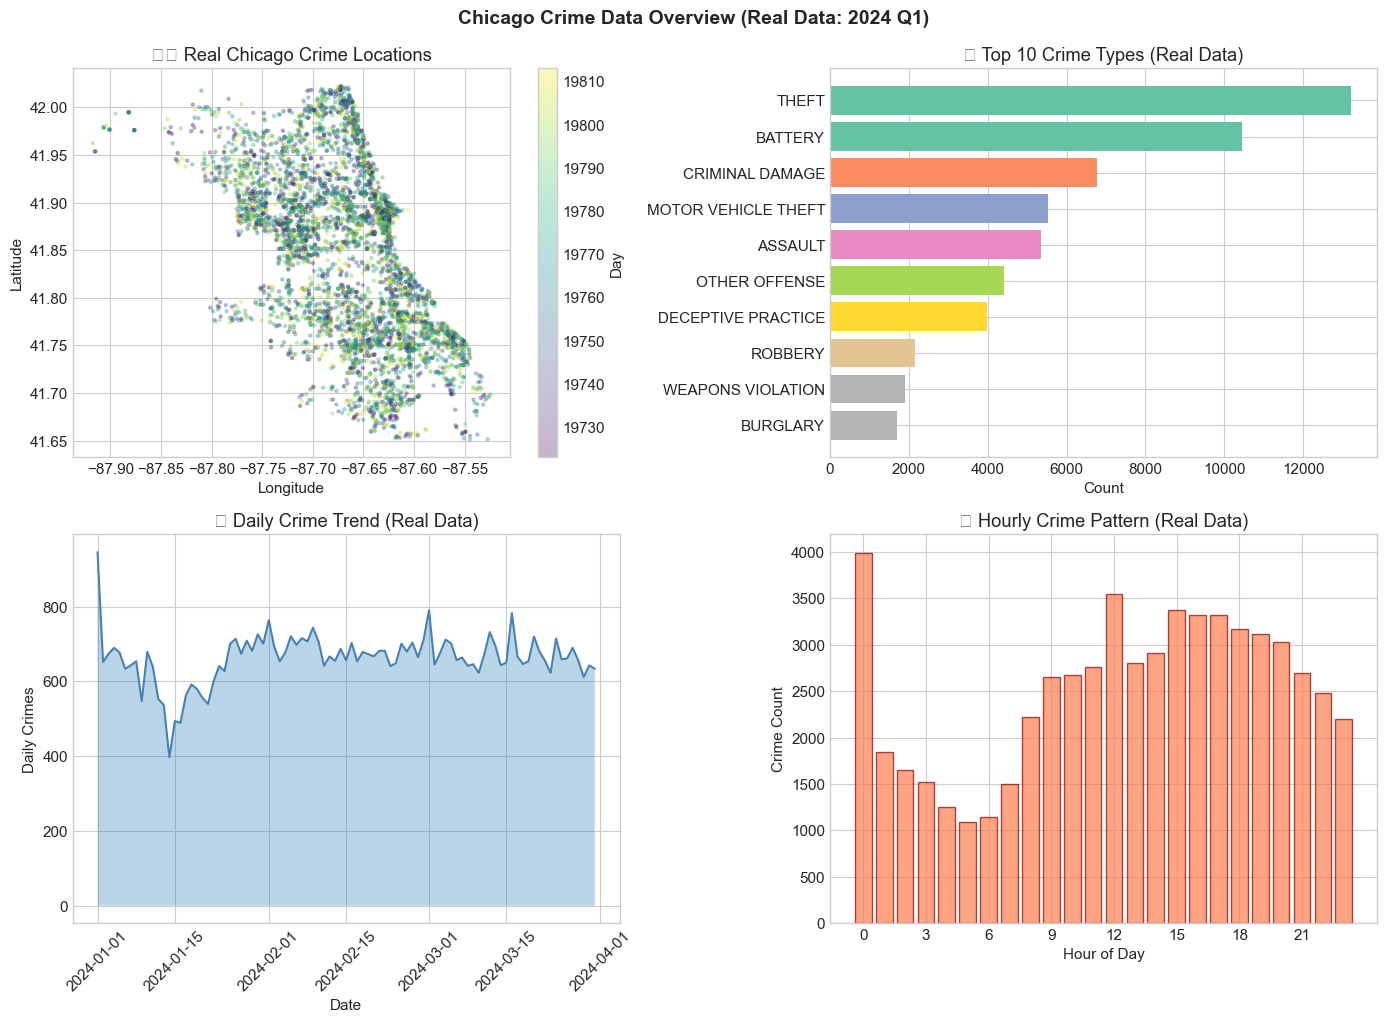

In [30]:
# Visualization: Real Crime Data Distribution Overview
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Spatial distribution (scatter plot) - REAL Chicago locations
ax1 = axes[0, 0]
sample_idx = np.random.choice(len(crime_df), min(5000, len(crime_df)), replace=False)
sample_df = crime_df[sample_idx]
scatter = ax1.scatter(
    sample_df["longitude"].to_numpy(), 
    sample_df["latitude"].to_numpy(),
    c=sample_df["timestamp"].to_numpy().astype('datetime64[D]').astype(int),
    cmap='viridis', alpha=0.3, s=5
)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title("🗺️ Real Chicago Crime Locations")
plt.colorbar(scatter, ax=ax1, label="Day")

# 2. Crime type distribution - TOP 10
ax2 = axes[0, 1]
type_counts = crime_df.group_by("primary_type").len().sort("len", descending=True).head(10)
colors = plt.cm.Set2(np.linspace(0, 1, len(type_counts)))
bars = ax2.barh(type_counts["primary_type"].to_numpy(), type_counts["len"].to_numpy(), color=colors)
ax2.set_xlabel("Count")
ax2.set_title("📊 Top 10 Crime Types (Real Data)")
ax2.invert_yaxis()

# 3. Daily crime counts over time
ax3 = axes[1, 0]
daily_totals = crime_df.with_columns(pl.col("timestamp").dt.date().alias("date")).group_by("date").len().sort("date")
ax3.plot(daily_totals["date"].to_numpy(), daily_totals["len"].to_numpy(), linewidth=1.5, color='steelblue')
ax3.fill_between(daily_totals["date"].to_numpy(), daily_totals["len"].to_numpy(), alpha=0.3)
ax3.set_xlabel("Date")
ax3.set_ylabel("Daily Crimes")
ax3.set_title("📈 Daily Crime Trend (Real Data)")
ax3.tick_params(axis='x', rotation=45)

# 4. Hourly pattern
ax4 = axes[1, 1]
hourly = crime_df.with_columns(pl.col("timestamp").dt.hour().alias("hour")).group_by("hour").len().sort("hour")
ax4.bar(hourly["hour"].to_numpy(), hourly["len"].to_numpy(), color='coral', edgecolor='darkred', alpha=0.7)
ax4.set_xlabel("Hour of Day")
ax4.set_ylabel("Crime Count")
ax4.set_title("🕐 Hourly Crime Pattern (Real Data)")
ax4.set_xticks(range(0, 24, 3))

plt.tight_layout()
plt.suptitle("Chicago Crime Data Overview (Real Data: 2024 Q1)", fontsize=14, fontweight='bold', y=1.02)
plt.show()

---

## 2. Create Spatial Grid Aggregation

Aggregate crimes by spatial grid cell and time window to create event counts suitable for modeling.

In [31]:
# Create spatial grid bins (10x10 grid over Chicago)
n_lat_bins, n_lon_bins = 10, 10

crime_df = crime_df.with_columns([
    ((pl.col("latitude") - lat_min) / (lat_max - lat_min) * n_lat_bins).floor().cast(pl.Int32).clip(0, n_lat_bins-1).alias("lat_bin"),
    ((pl.col("longitude") - lon_min) / (lon_max - lon_min) * n_lon_bins).floor().cast(pl.Int32).clip(0, n_lon_bins-1).alias("lon_bin"),
    pl.col("timestamp").dt.date().alias("date"),
    pl.col("timestamp").dt.hour().alias("hour"),
])

# Create spatial cell ID
crime_df = crime_df.with_columns(
    (pl.col("lat_bin") * n_lon_bins + pl.col("lon_bin")).alias("cell_id")
)

# Aggregate by cell and date
daily_counts = crime_df.group_by(["cell_id", "date", "lat_bin", "lon_bin"]).agg([
    pl.len().alias("event_count"),
    pl.col("arrest").sum().alias("arrest_count"),
    pl.col("domestic").sum().alias("domestic_count"),
    pl.col("latitude").mean().alias("centroid_lat"),
    pl.col("longitude").mean().alias("centroid_lon"),
]).sort(["date", "cell_id"])

print(f"📊 Aggregated to {len(daily_counts):,} cell-day observations")
print(f"🗓️ Unique dates: {daily_counts['date'].n_unique()}")
print(f"📍 Unique cells: {daily_counts['cell_id'].n_unique()}")
daily_counts.head(10)

📊 Aggregated to 4,687 cell-day observations
🗓️ Unique dates: 91
📍 Unique cells: 59


cell_id,date,lat_bin,lon_bin,event_count,arrest_count,domestic_count,centroid_lat,centroid_lon
i32,date,i32,i32,u32,u32,u32,f64,f64
6,2024-01-01,0,6,2,0,0,41.673445,-87.653975
7,2024-01-01,0,7,14,2,7,41.669062,-87.629134
8,2024-01-01,0,8,3,0,1,41.656898,-87.598304
9,2024-01-01,0,9,4,0,2,41.651142,-87.540662
16,2024-01-01,1,6,14,2,6,41.693975,-87.664219
17,2024-01-01,1,7,39,3,12,41.694967,-87.624652
18,2024-01-01,1,8,4,0,1,41.70231,-87.564592
19,2024-01-01,1,9,7,0,1,41.70315,-87.533798
24,2024-01-01,2,4,2,0,1,41.739602,-87.73331


---

## 3. TableAdapter — For GLM/Poisson Regression

Convert to tabular format suitable for count regression models with offset for exposure.

**Output:** `(N, F)` feature matrix + target vector

In [32]:
# Prepare features for TableAdapter
# Add day-of-week and exposure (log area proxy)
table_df = daily_counts.with_columns([
    pl.col("date").dt.weekday().alias("day_of_week"),
    pl.lit(1.0).alias("exposure"),  # uniform exposure for this demo
])

# Configure TableAdapter
table_config = TableAdapterConfig(
    target_col="event_count",
    feature_cols=["lat_bin", "lon_bin", "day_of_week", "arrest_count", "domestic_count"],
    offset_col="exposure",
    include_intercept=True,
)

table_adapter = TableAdapter(table_config)
table_output = table_adapter.convert(table_df)

print(f"Table shape: {table_output.data.shape}")
print(f"Feature names: {table_output.feature_names}")
print(f"Target column: {table_output.target}")

# Get X, y for sklearn
X, y = table_output.get_X_y()
print(f"\nX shape: {X.shape}, y shape: {y.shape if y is not None else 'None'}")
print(f"X[:5]:\n{X[:5]}")

2025-12-08 10:23:40,794 - eventflow.core.adapters.table - INFO - Converting EventFrame to table format
2025-12-08 10:23:40,794 - eventflow.core.adapters.table - INFO - Created table with 4687 rows, 6 features
2025-12-08 10:23:40,794 - eventflow.core.adapters.table - INFO - Created table with 4687 rows, 6 features


Table shape: (4687, 8)
Feature names: ['_intercept', 'lat_bin', 'lon_bin', 'day_of_week', 'arrest_count', 'domestic_count']
Target column: event_count

X shape: (4687, 6), y shape: (4687,)
X[:5]:
[[1. 0. 6. 1. 0. 0.]
 [1. 0. 7. 1. 2. 7.]
 [1. 0. 8. 1. 0. 1.]
 [1. 0. 9. 1. 0. 2.]
 [1. 1. 6. 1. 2. 6.]]


c:\Users\Administrator\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Administrator\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\2369276442.py:38: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\2369276442.py:38: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\2369276442.py:38: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Administrator\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(b

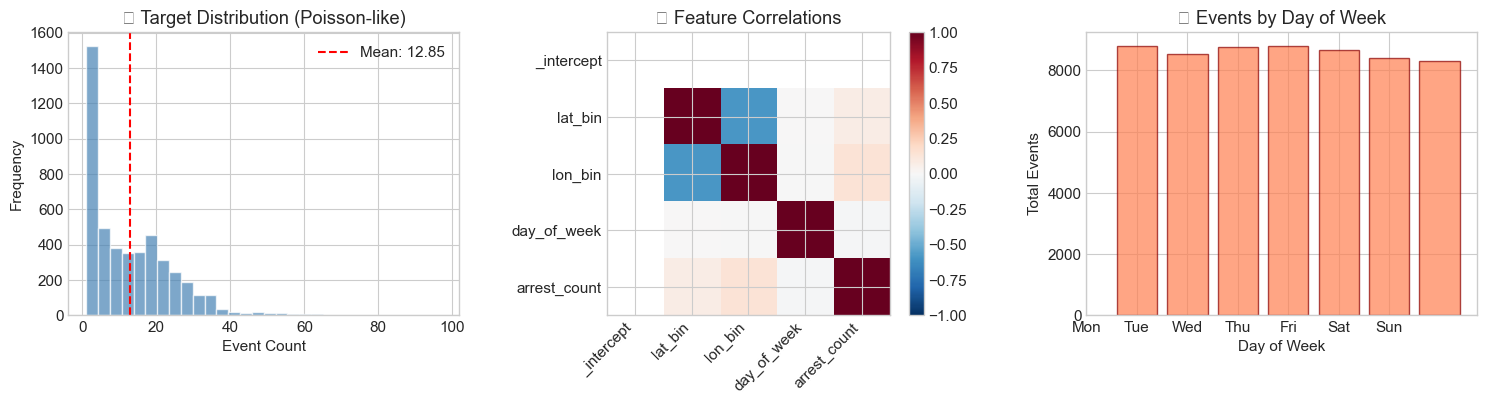

✅ TableAdapter ready for sklearn/statsmodels


In [33]:
# Visualization: TableAdapter Output
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Target distribution
ax1 = axes[0]
ax1.hist(y, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(np.mean(y), color='red', linestyle='--', label=f'Mean: {np.mean(y):.2f}')
ax1.set_xlabel("Event Count")
ax1.set_ylabel("Frequency")
ax1.set_title("📊 Target Distribution (Poisson-like)")
ax1.legend()

# 2. Feature correlation heatmap
ax2 = axes[1]
feature_names = table_output.feature_names[:5]  # First 5 features
corr_matrix = np.corrcoef(X[:, :5].T)
im = ax2.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_xticks(range(len(feature_names)))
ax2.set_yticks(range(len(feature_names)))
ax2.set_xticklabels(feature_names, rotation=45, ha='right')
ax2.set_yticklabels(feature_names)
ax2.set_title("🔗 Feature Correlations")
plt.colorbar(im, ax=ax2)

# 3. Day of week pattern
ax3 = axes[2]
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_idx = table_df.columns.index("day_of_week") if "day_of_week" in table_df.columns else 2
dow_data = table_df.group_by("day_of_week").agg(pl.col("event_count").sum()).sort("day_of_week")
ax3.bar(dow_data["day_of_week"].to_numpy(), dow_data["event_count"].to_numpy(), 
        color='coral', edgecolor='darkred', alpha=0.7)
ax3.set_xticks(range(7))
ax3.set_xticklabels(dow_labels)
ax3.set_xlabel("Day of Week")
ax3.set_ylabel("Total Events")
ax3.set_title("📅 Events by Day of Week")

plt.tight_layout()
plt.show()

print(f"✅ TableAdapter ready for sklearn/statsmodels")

---

## 4. SequenceAdapter — For RNN/Transformer Models

Convert time series per location into padded sequences with attention masks.

**Output:** `(B, T, F)` tensor + attention masks

In [34]:
# Prepare sequences: each cell's time series
sequence_data = daily_counts.select(["cell_id", "date", "event_count"]).sort(["cell_id", "date"])

print(f"Sequence data rows: {len(sequence_data)}")

# Configure SequenceAdapter - using the aggregated data directly
seq_config = SequenceAdapterConfig(
    spatial_col="cell_id",
    timestamp_col="date",
    feature_cols=["event_count"],
    sequence_length=30,  # max 30 days
    padding_value=0.0,
    padding_side="right",
)

seq_adapter = SequenceAdapter(seq_config)
seq_output = seq_adapter.convert(sequence_data)

print(f"\nSequence tensor shape: {seq_output.sequences.shape}")
print(f"Attention mask shape: {seq_output.masks.shape}")
print(f"Sequence lengths (first 10): {seq_output.lengths[:10]}")
print(f"\nFirst sequence (first 10 values): {seq_output.sequences[0, :10]}")
print(f"First mask (first 10 values): {seq_output.masks[0, :10]}")

2025-12-08 10:24:02,641 - eventflow.core.adapters.sequence - INFO - Converting EventFrame to sequence format
2025-12-08 10:24:02,666 - eventflow.core.adapters.sequence - INFO - Created 59 sequences with max_length=30, n_features=1
2025-12-08 10:24:02,666 - eventflow.core.adapters.sequence - INFO - Created 59 sequences with max_length=30, n_features=1


Sequence data rows: 4687

Sequence tensor shape: (59, 30, 1)
Attention mask shape: (59, 30)
Sequence lengths (first 10): [47 91 65 80 65 91 91 89 91 62]

First sequence (first 10 values): [[2.]
 [1.]
 [3.]
 [2.]
 [2.]
 [2.]
 [3.]
 [1.]
 [2.]
 [1.]]
First mask (first 10 values): [ True  True  True  True  True  True  True  True  True  True]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\3220420571.py:47: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\3220420571.py:47: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\3220420571.py:47: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\3220420571.py:47: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Administrator\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Administrator\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT

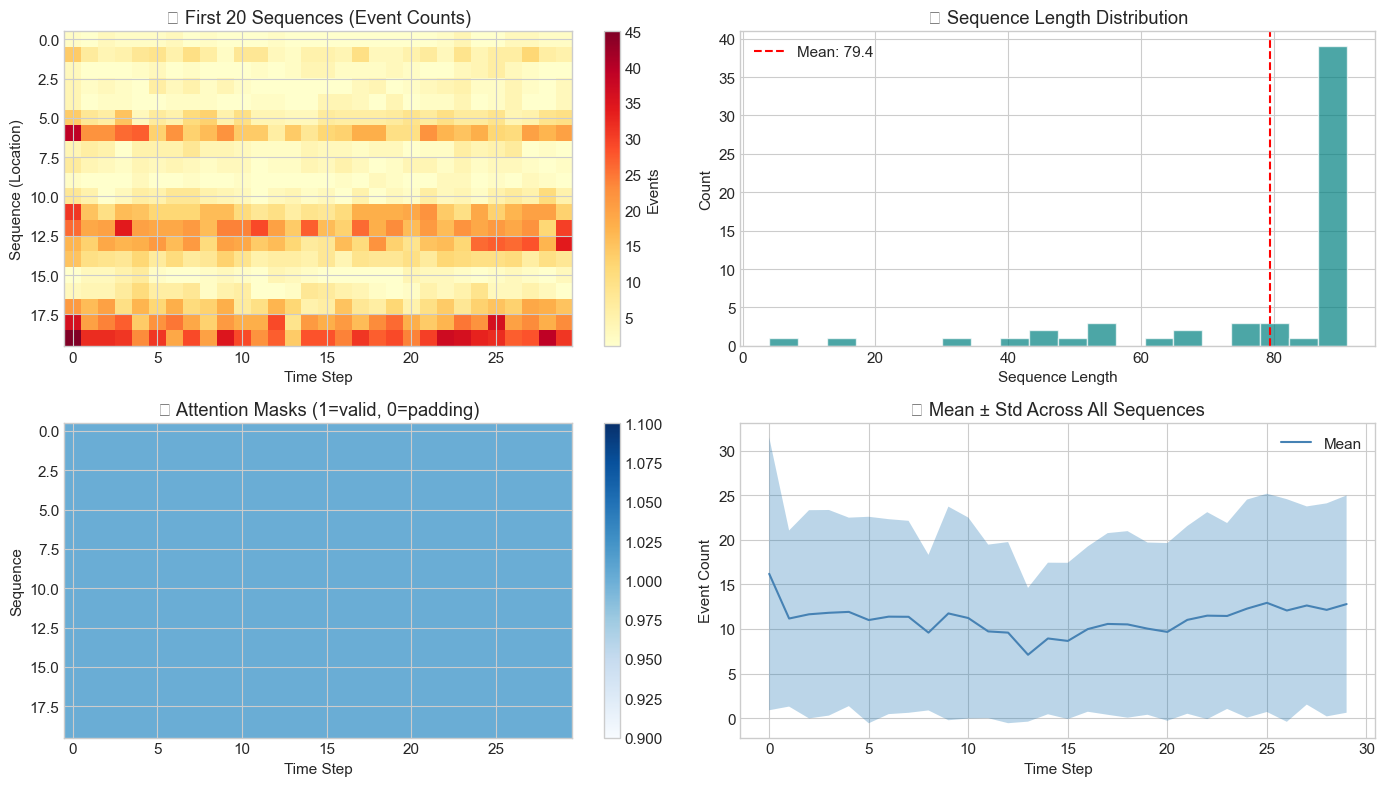

✅ SequenceAdapter ready for PyTorch/TensorFlow RNN/Transformer


In [35]:
# Visualization: SequenceAdapter Output
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

sequences = seq_output.sequences
masks = seq_output.masks

# 1. Sample sequences heatmap
ax1 = axes[0, 0]
n_show = min(20, sequences.shape[0])
im1 = ax1.imshow(sequences[:n_show, :, 0], aspect='auto', cmap='YlOrRd')
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Sequence (Location)")
ax1.set_title(f"🔥 First {n_show} Sequences (Event Counts)")
plt.colorbar(im1, ax=ax1, label="Events")

# 2. Sequence length distribution
ax2 = axes[0, 1]
lengths = seq_output.lengths
ax2.hist(lengths, bins=20, color='teal', edgecolor='white', alpha=0.7)
ax2.axvline(np.mean(lengths), color='red', linestyle='--', label=f'Mean: {np.mean(lengths):.1f}')
ax2.set_xlabel("Sequence Length")
ax2.set_ylabel("Count")
ax2.set_title("📏 Sequence Length Distribution")
ax2.legend()

# 3. Attention mask visualization
ax3 = axes[1, 0]
im3 = ax3.imshow(masks[:n_show], aspect='auto', cmap='Blues')
ax3.set_xlabel("Time Step")
ax3.set_ylabel("Sequence")
ax3.set_title("🎭 Attention Masks (1=valid, 0=padding)")
plt.colorbar(im3, ax=ax3)

# 4. Temporal statistics per position
ax4 = axes[1, 1]
mean_per_position = np.nanmean(np.where(masks[:, :, None] if masks.ndim == 2 else masks, sequences, np.nan), axis=0)
std_per_position = np.nanstd(np.where(masks[:, :, None] if masks.ndim == 2 else masks, sequences, np.nan), axis=0)
x = np.arange(mean_per_position.shape[0])
ax4.plot(x, mean_per_position[:, 0], color='steelblue', label='Mean')
ax4.fill_between(x, mean_per_position[:, 0] - std_per_position[:, 0], 
                 mean_per_position[:, 0] + std_per_position[:, 0], alpha=0.3)
ax4.set_xlabel("Time Step")
ax4.set_ylabel("Event Count")
ax4.set_title("📈 Mean ± Std Across All Sequences")
ax4.legend()

plt.tight_layout()
plt.show()

print(f"✅ SequenceAdapter ready for PyTorch/TensorFlow RNN/Transformer")

---

## 5. RasterAdapter — For CNN Models

Convert spatial-temporal data into 4D arrays (time × channels × height × width) for convolutional networks.

**Output:** `(T, C, H, W)` tensor for ConvLSTM/U-Net

In [36]:
# Configure RasterAdapter
raster_config = RasterAdapterConfig(
    grid_col="cell_id",
    timestamp_col="date",
    feature_cols=["event_count", "arrest_count"],
    grid_shape=(n_lat_bins, n_lon_bins),
    channel_first=True,  # PyTorch format: (C, H, W)
    fill_value=0.0,
)

raster_adapter = RasterAdapter(raster_config)
raster_output = raster_adapter.convert(daily_counts)

print(f"Raster shape: {raster_output.raster.shape}")
print(f"Shape interpretation: (time_steps, channels, height, width)")
print(f"Timestamps: {len(raster_output.timestamps)} unique dates")
print(f"Channels: {raster_output.channel_names}")
print(f"\nFirst timestep, first channel (event_count) - 10x10 grid:\n{raster_output.raster[0, 0]}")

2025-12-08 10:24:21,589 - eventflow.core.adapters.raster - INFO - Converting EventFrame to raster format
2025-12-08 10:24:21,606 - eventflow.core.adapters.raster - INFO - Created raster with shape (91, 2, 10, 10): 91 timesteps, 2 channels, 10x10 grid
2025-12-08 10:24:21,606 - eventflow.core.adapters.raster - INFO - Created raster with shape (91, 2, 10, 10): 91 timesteps, 2 channels, 10x10 grid


Raster shape: (91, 2, 10, 10)
Shape interpretation: (time_steps, channels, height, width)
Timestamps: 91 unique dates
Channels: ['event_count', 'arrest_count']

First timestep, first channel (event_count) - 10x10 grid:
[[ 2. 14.  3.  4.  0. 14. 39.  4.  7.  2.]
 [ 8. 31. 26. 17. 15.  1.  3. 21. 36. 45.]
 [33.  4.  2.  6. 16. 19. 38. 13.  0.  5.]
 [45. 20. 21.  3. 54. 38. 34. 63.  0. 20.]
 [29. 29. 21. 11.  2.  2.  6.  8. 10. 28.]
 [24.  1.  0.  0.  2.  6.  1.  5. 35.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\3089166843.py:47: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\3089166843.py:47: UserWarning: Glyph 128660 (\N{ONCOMING POLICE CAR}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\3089166843.py:47: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\3089166843.py:47: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Administrator\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128660 (\N{ONCOMING POLICE CAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Administrator\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 1

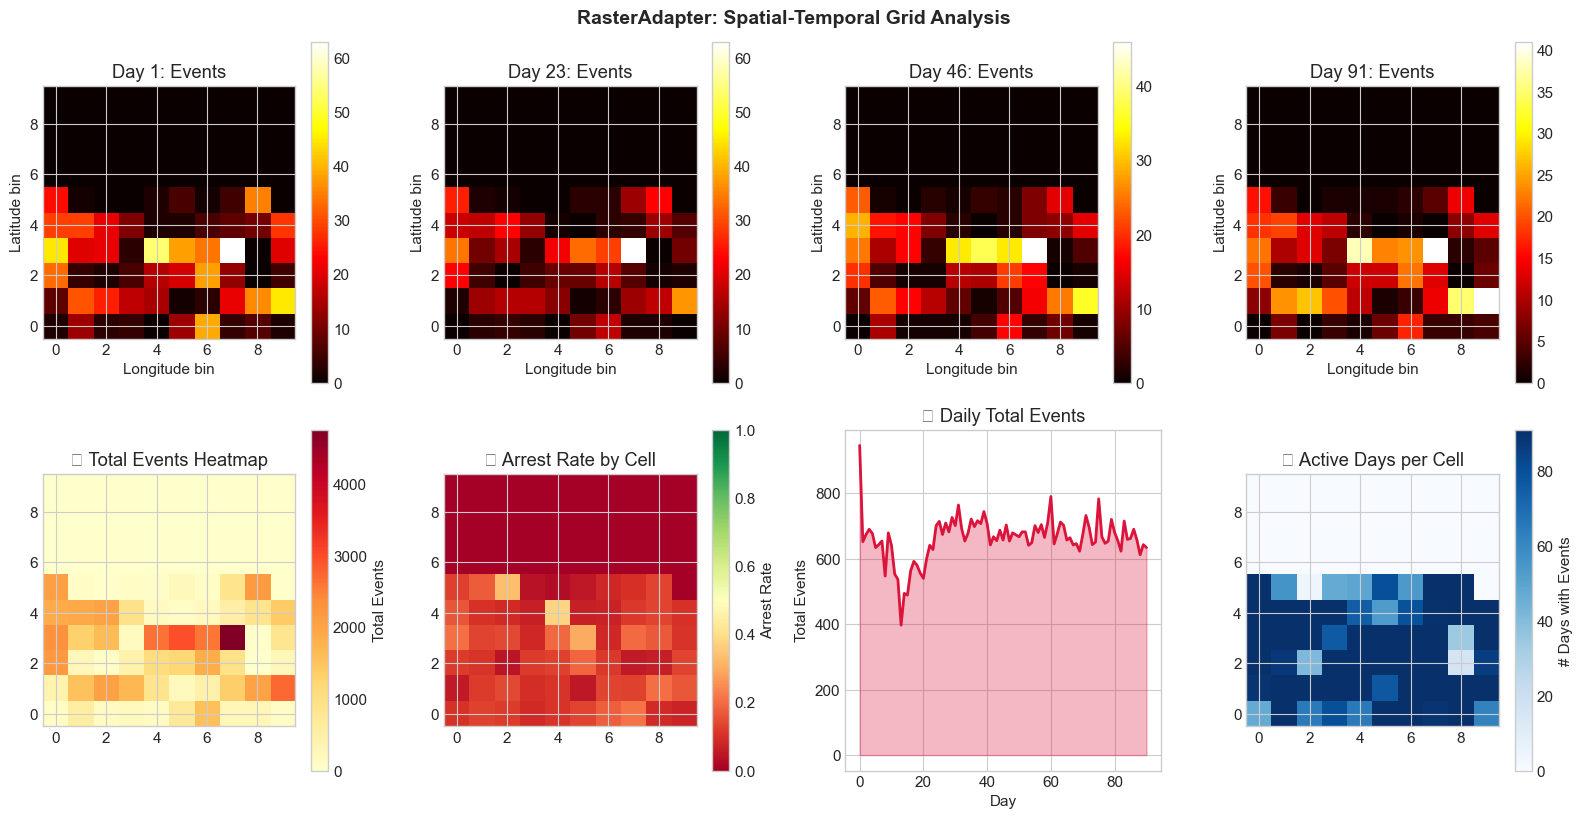

✅ RasterAdapter ready for PyTorch Conv2D/ConvLSTM


In [37]:
# Visualization: RasterAdapter Output
raster_data = raster_output.raster

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Top row: Event count channel across time
for i, t_idx in enumerate([0, len(raster_data)//4, len(raster_data)//2, len(raster_data)-1]):
    ax = axes[0, i]
    im = ax.imshow(raster_data[t_idx, 0], cmap='hot', origin='lower')
    ax.set_title(f"Day {t_idx+1}: Events")
    ax.set_xlabel("Longitude bin")
    ax.set_ylabel("Latitude bin")
    plt.colorbar(im, ax=ax)

# Bottom row: Different analyses
# 1. Total events heatmap
ax = axes[1, 0]
total_events = raster_data[:, 0].sum(axis=0)
im = ax.imshow(total_events, cmap='YlOrRd', origin='lower')
ax.set_title("🔥 Total Events Heatmap")
plt.colorbar(im, ax=ax, label="Total Events")

# 2. Arrest rate heatmap
ax = axes[1, 1]
total_arrests = raster_data[:, 1].sum(axis=0) if raster_data.shape[1] > 1 else np.zeros_like(total_events)
arrest_rate = np.divide(total_arrests, total_events, where=total_events > 0, out=np.zeros_like(total_events, dtype=float))
im = ax.imshow(arrest_rate, cmap='RdYlGn', origin='lower', vmin=0, vmax=1)
ax.set_title("🚔 Arrest Rate by Cell")
plt.colorbar(im, ax=ax, label="Arrest Rate")

# 3. Temporal evolution
ax = axes[1, 2]
daily_totals = raster_data[:, 0].sum(axis=(1, 2))
ax.plot(daily_totals, linewidth=2, color='crimson')
ax.fill_between(range(len(daily_totals)), daily_totals, alpha=0.3, color='crimson')
ax.set_xlabel("Day")
ax.set_ylabel("Total Events")
ax.set_title("📈 Daily Total Events")

# 4. Hotspot persistence
ax = axes[1, 3]
active_days = (raster_data[:, 0] > 0).sum(axis=0)
im = ax.imshow(active_days, cmap='Blues', origin='lower')
ax.set_title("📍 Active Days per Cell")
plt.colorbar(im, ax=ax, label="# Days with Events")

plt.tight_layout()
plt.suptitle("RasterAdapter: Spatial-Temporal Grid Analysis", fontsize=14, fontweight='bold', y=1.02)
plt.show()

print(f"✅ RasterAdapter ready for PyTorch Conv2D/ConvLSTM")

---

## 6. GraphAdapter — For GNN Models

Convert spatial relationships into graph structure with node features and adjacency matrix.

**Output:** Node features + Edge index (PyTorch Geometric format)

In [38]:
# Prepare graph data: nodes are cells, edges connect neighbors
# Aggregate features per cell (across all dates)
node_features_df = daily_counts.group_by("cell_id").agg([
    pl.col("event_count").sum().alias("total_events"),
    pl.col("event_count").mean().alias("avg_events"),
    pl.col("arrest_count").sum().alias("total_arrests"),
    pl.col("centroid_lat").mean().alias("lat"),
    pl.col("centroid_lon").mean().alias("lon"),
    pl.col("lat_bin").first().alias("lat_bin"),
    pl.col("lon_bin").first().alias("lon_bin"),
]).sort("cell_id")

print(f"Nodes (cells): {len(node_features_df)}")

# Configure GraphAdapter
graph_config = GraphAdapterConfig(
    node_col="cell_id",
    feature_cols=["total_events", "avg_events", "total_arrests", "lat", "lon"],
    adjacency_type="spatial",
    spatial_threshold=0.05,  # connect nodes within ~5km
    include_self_loops=True,
)

graph_adapter = GraphAdapter(graph_config)
graph_output = graph_adapter.convert(node_features_df)

print(f"\nNode features shape: {graph_output.node_features.shape}")
print(f"Edge index shape: {graph_output.edge_index.shape}")
print(f"Number of edges: {graph_output.edge_index.shape[1]}")
print(f"Adjacency matrix shape: {graph_output.adjacency.shape}")
print(f"\nFirst 5 edges (src → dst): {list(zip(graph_output.edge_index[0, :5], graph_output.edge_index[1, :5]))}")

2025-12-08 10:24:41,537 - eventflow.core.adapters.graph - INFO - Converting EventFrame to graph format
2025-12-08 10:24:41,558 - eventflow.core.adapters.graph - INFO - Created graph with 59 nodes, 299 edges, 5 features
2025-12-08 10:24:41,558 - eventflow.core.adapters.graph - INFO - Created graph with 59 nodes, 299 edges, 5 features


Nodes (cells): 59

Node features shape: (59, 5)
Edge index shape: (2, 299)
Number of edges: 299
Adjacency matrix shape: (59, 59)

First 5 edges (src → dst): [(0, 1), (1, 0), (0, 5), (5, 0), (0, 6)]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\1877779941.py:55: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\1877779941.py:55: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\1877779941.py:55: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\1877779941.py:55: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Administrator\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Administrator\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (

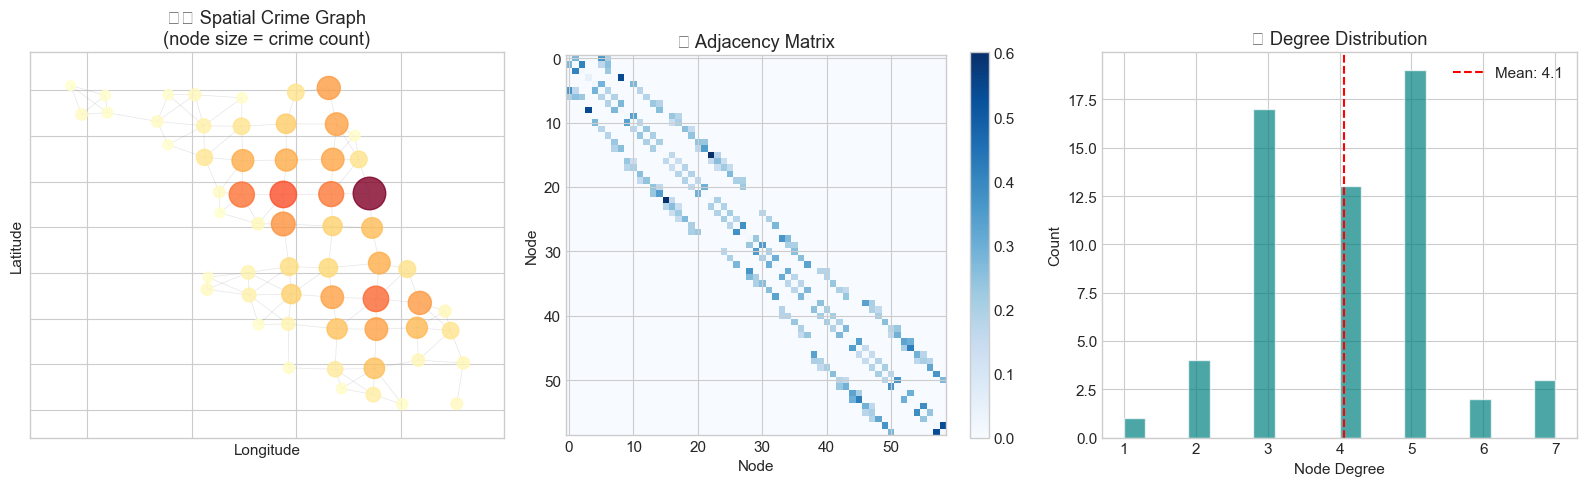

✅ GraphAdapter ready for PyTorch Geometric GCN/GAT


In [39]:
# Visualization: GraphAdapter Output
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Build NetworkX graph for visualization
G = nx.Graph()
node_features = graph_output.node_features
edge_index = graph_output.edge_index

# Add nodes with features
for i in range(len(node_features)):
    G.add_node(i, total_events=node_features[i, 0])

# Add edges
for i in range(edge_index.shape[1]):
    src, dst = edge_index[0, i], edge_index[1, i]
    if src != dst:  # Skip self-loops for visualization
        G.add_edge(int(src), int(dst))

# 1. Graph visualization with node size = crime count
ax1 = axes[0]
pos = {}
for i, row in enumerate(node_features_df.iter_rows(named=True)):
    pos[i] = (row['lon'], row['lat'])

node_sizes = node_features[:, 0]  # total_events
node_sizes_scaled = 50 + (node_sizes - node_sizes.min()) / (node_sizes.max() - node_sizes.min() + 1e-6) * 500
node_colors = node_features[:, 0]

nx.draw_networkx_nodes(G, pos, ax=ax1, node_size=node_sizes_scaled, 
                       node_color=node_colors, cmap='YlOrRd', alpha=0.8)
nx.draw_networkx_edges(G, pos, ax=ax1, alpha=0.2, width=0.5, edge_color='gray')
ax1.set_title("🕸️ Spatial Crime Graph\n(node size = crime count)")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# 2. Adjacency matrix
ax2 = axes[1]
adj_dense = graph_output.adjacency if hasattr(graph_output, 'adjacency') else np.zeros((len(node_features), len(node_features)))
im = ax2.imshow(adj_dense, cmap='Blues')
ax2.set_title("📊 Adjacency Matrix")
ax2.set_xlabel("Node")
ax2.set_ylabel("Node")
plt.colorbar(im, ax=ax2)

# 3. Degree distribution
ax3 = axes[2]
degrees = [G.degree(n) for n in G.nodes()]
ax3.hist(degrees, bins=20, color='teal', edgecolor='white', alpha=0.7)
ax3.axvline(np.mean(degrees), color='red', linestyle='--', label=f'Mean: {np.mean(degrees):.1f}')
ax3.set_xlabel("Node Degree")
ax3.set_ylabel("Count")
ax3.set_title("📈 Degree Distribution")
ax3.legend()

plt.tight_layout()
plt.show()

print(f"✅ GraphAdapter ready for PyTorch Geometric GCN/GAT")

---

## 7. StreamAdapter — For Neural ODE / Point Process Models

Convert to continuous-time event streams with inter-event times for temporal point processes.

**Output:** Timestamps, inter-event times, event types, state features

In [40]:
# Use original crime events (not aggregated) for stream - sample for performance
stream_df = crime_df.select([
    "case_number",
    "timestamp",
    "primary_type",
    "cell_id",
    "latitude",
    "longitude",
]).sort("timestamp").head(10000)  # Sample 10k for demo

print(f"📊 Events for streaming: {len(stream_df):,}")

# Configure StreamAdapter
stream_config = StreamAdapterConfig(
    timestamp_col="timestamp",
    event_type_col="primary_type",
    state_cols=["latitude", "longitude"],
    time_scale="normalize",  # normalize timestamps
    time_origin="first",  # relative to first event
)

stream_adapter = StreamAdapter(stream_config)
stream_output = stream_adapter.convert(stream_df)

print(f"\n📈 Timestamps shape: {stream_output.timestamps.shape}")
print(f"🗺️ States shape: {stream_output.states.shape}")
print(f"⏱️ Inter-event times shape: {stream_output.inter_times.shape}")
print(f"🏷️ Event types shape: {stream_output.event_types.shape}")
print(f"📊 Unique event types: {len(np.unique(stream_output.event_types))}")
print(f"\n🕐 First 10 normalized timestamps: {stream_output.timestamps[:10]}")
print(f"⏱️ First 10 inter-event times: {stream_output.inter_times[:10]}")

2025-12-08 10:25:11,351 - eventflow.core.adapters.stream - INFO - Converting EventFrame to stream format
2025-12-08 10:25:11,368 - eventflow.core.adapters.stream - INFO - Created stream with 10000 events, 2 state dims
2025-12-08 10:25:11,368 - eventflow.core.adapters.stream - INFO - Created stream with 10000 events, 2 state dims


📊 Events for streaming: 10,000

📈 Timestamps shape: (10000,)
🗺️ States shape: (10000, 2)
⏱️ Inter-event times shape: (10000,)
🏷️ Event types shape: (10000,)
📊 Unique event types: 27

🕐 First 10 normalized timestamps: [-1.5844063 -1.5844063 -1.5844063 -1.5844063 -1.5844063 -1.5844063
 -1.5844063 -1.5844063 -1.5844063 -1.5844063]
⏱️ First 10 inter-event times: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\4222347727.py:71: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\4222347727.py:71: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\4222347727.py:71: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\4222347727.py:71: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\4222347727.py:71: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17132\4222347727.py:71: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) A

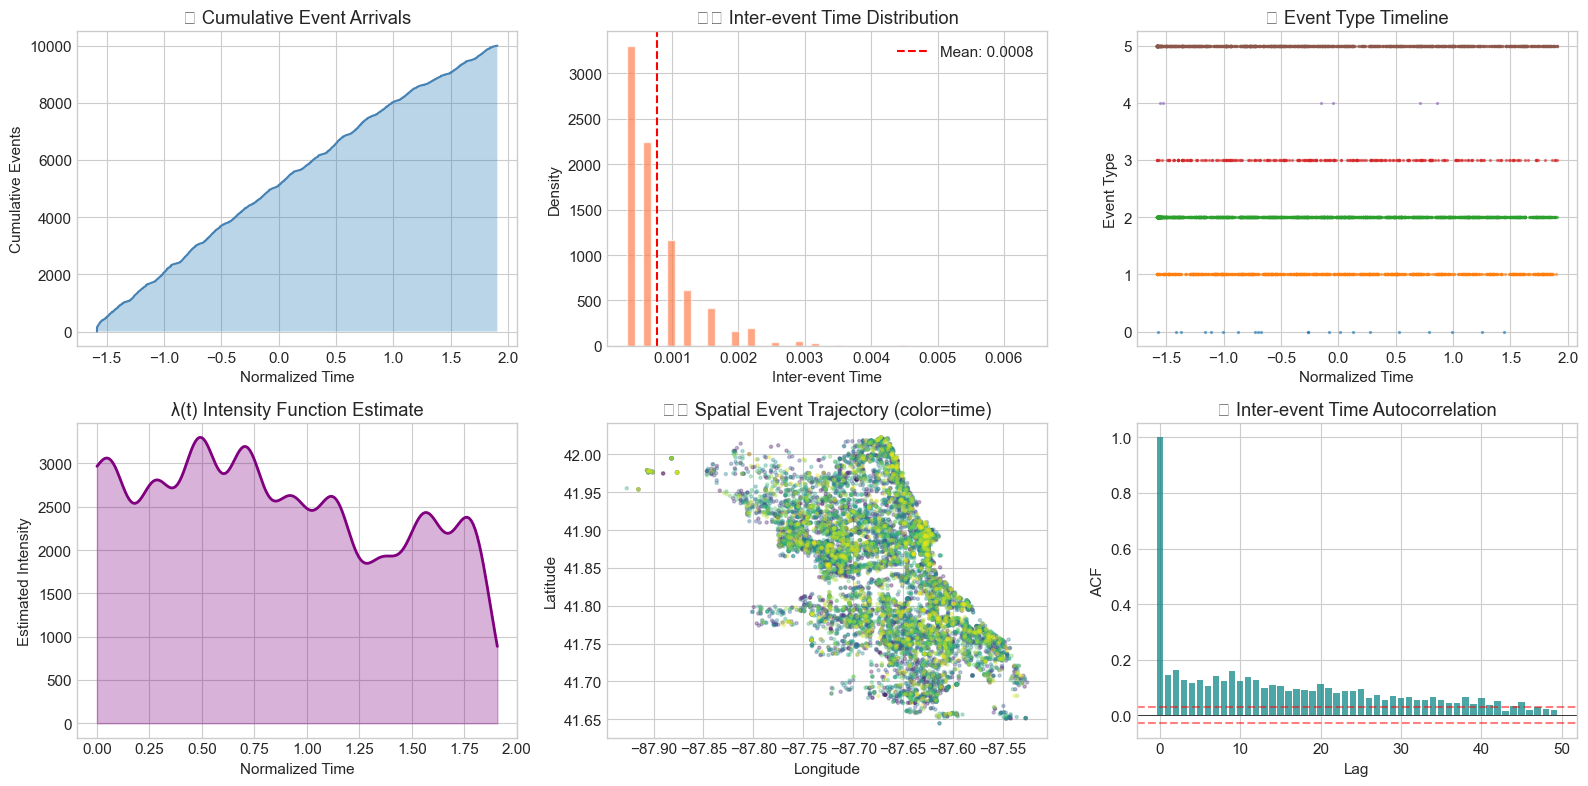


📊 Point Process Statistics:
   Events: 10,000
   Arrival rate (λ): 2864.19 events/unit time
   Mean inter-event time: 0.0008
   CV (=1 for Poisson): 0.79

✅ StreamAdapter ready for Neural ODE / Hawkes Process models


In [41]:
# Visualization: StreamAdapter Output
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

timestamps = stream_output.timestamps
inter_times = stream_output.inter_times
event_types = stream_output.event_types
states = stream_output.states

# 1. Cumulative events over time
ax1 = axes[0, 0]
ax1.plot(timestamps, np.arange(len(timestamps)), linewidth=1.5, color='steelblue')
ax1.set_xlabel("Normalized Time")
ax1.set_ylabel("Cumulative Events")
ax1.set_title("📈 Cumulative Event Arrivals")
ax1.fill_between(timestamps, np.arange(len(timestamps)), alpha=0.3)

# 2. Inter-event time distribution
ax2 = axes[0, 1]
inter_times_clean = inter_times[inter_times > 0]
ax2.hist(inter_times_clean, bins=50, color='coral', edgecolor='white', alpha=0.7, density=True)
ax2.axvline(np.mean(inter_times_clean), color='red', linestyle='--', label=f'Mean: {np.mean(inter_times_clean):.4f}')
ax2.set_xlabel("Inter-event Time")
ax2.set_ylabel("Density")
ax2.set_title("⏱️ Inter-event Time Distribution")
ax2.legend()

# 3. Event types over time
ax3 = axes[0, 2]
unique_types = np.unique(event_types)
for i, et in enumerate(unique_types[:6]):  # Limit to 6 types for clarity
    mask = event_types == et
    ax3.scatter(timestamps[mask], np.ones(mask.sum()) * i, alpha=0.5, s=2, label=str(et))
ax3.set_xlabel("Normalized Time")
ax3.set_ylabel("Event Type")
ax3.set_title("🎯 Event Type Timeline")
ax3.set_yticks(range(min(6, len(unique_types))))
ax3.set_yticklabels([str(t) for t in unique_types[:6]])

# 4. Intensity estimation (kernel smoothing)
ax4 = axes[1, 0]
t_grid = np.linspace(0, timestamps.max(), 200)
bandwidth = (timestamps.max() - timestamps.min()) / 50
intensity_est = np.array([np.sum(np.exp(-0.5 * ((t - timestamps) / bandwidth) ** 2)) / (len(timestamps) * bandwidth * np.sqrt(2 * np.pi)) for t in t_grid])
ax4.plot(t_grid, intensity_est * len(timestamps), linewidth=2, color='purple')
ax4.fill_between(t_grid, intensity_est * len(timestamps), alpha=0.3, color='purple')
ax4.set_xlabel("Normalized Time")
ax4.set_ylabel("Estimated Intensity")
ax4.set_title("λ(t) Intensity Function Estimate")

# 5. Spatial trajectory
ax5 = axes[1, 1]
ax5.scatter(states[:, 1], states[:, 0], c=timestamps, cmap='viridis', alpha=0.3, s=5)
ax5.set_xlabel("Longitude")
ax5.set_ylabel("Latitude")
ax5.set_title("🗺️ Spatial Event Trajectory (color=time)")

# 6. Autocorrelation of inter-event times
ax6 = axes[1, 2]
lags = min(50, len(inter_times_clean) // 4)
acf = np.correlate(inter_times_clean - np.mean(inter_times_clean), 
                   inter_times_clean - np.mean(inter_times_clean), mode='full')
acf = acf[len(acf)//2:len(acf)//2 + lags] / acf[len(acf)//2]
ax6.bar(range(lags), acf, color='teal', alpha=0.7)
ax6.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax6.axhline(1.96/np.sqrt(len(inter_times_clean)), color='red', linestyle='--', alpha=0.5)
ax6.axhline(-1.96/np.sqrt(len(inter_times_clean)), color='red', linestyle='--', alpha=0.5)
ax6.set_xlabel("Lag")
ax6.set_ylabel("ACF")
ax6.set_title("📊 Inter-event Time Autocorrelation")

plt.tight_layout()
plt.show()

# Point process statistics
total_time = timestamps.max() - timestamps.min()
arrival_rate = len(timestamps) / total_time
mean_inter = np.mean(inter_times_clean)
var_inter = np.var(inter_times_clean)
cv = np.sqrt(var_inter) / mean_inter  # Coefficient of variation

print(f"\n📊 Point Process Statistics:")
print(f"   Events: {len(timestamps):,}")
print(f"   Arrival rate (λ): {arrival_rate:.2f} events/unit time")
print(f"   Mean inter-event time: {mean_inter:.4f}")
print(f"   CV (=1 for Poisson): {cv:.2f}")
print(f"\n✅ StreamAdapter ready for Neural ODE / Hawkes Process models")

---

## 📊 Summary: EventFlow Multi-Modal Adapters

This notebook demonstrated how **EventFlow transforms real Chicago crime data into 5 different ML-ready formats**:

| Adapter | Shape | Output | Use Case |
|---------|-------|--------|----------|
| **TableAdapter** | `(N, F)` | X, y matrices | GLM, XGBoost, Random Forest |
| **SequenceAdapter** | `(B, T, F)` | Padded tensors + masks | LSTM, Transformer, Temporal CNN |
| **RasterAdapter** | `(T, C, H, W)` | 4D arrays | CNN, ConvLSTM, U-Net |
| **GraphAdapter** | Nodes + Edges | PyG-compatible | GCN, GAT, GraphSAGE |
| **StreamAdapter** | Timestamps | Continuous events | Neural ODE, Hawkes, TPP |

### Data Source:
- **Chicago Data Portal**: https://data.cityofchicago.org
- **Downloaded via**: `chicago_crime_data_cli` tool
- **Records**: 60,000+ real crime incidents from 2024 Q1

### Key Features:
- 🚀 **Lazy evaluation** with Polars for efficient processing
- 🔄 **Same data → multiple formats** for ensemble/multi-modal models  
- 📦 **Serialization** to Parquet, NumPy, PyTorch formats
- ✅ **Validated** with 290+ tests

### Next Steps:
- See [TODO.md](../TODO.md) for production roadmap
- Explore `src/eventflow/core/steps/` for pipeline steps
- Check `configs/` for YAML-based recipe configuration